In [1]:
import os
import glob
import pandas as pd
import numpy as np

In [25]:
os.getcwd()

'C:\\Users\\s6ujos\\Fannie Mae\\OneDrive - Fannie Mae\\Hackathon Challenges\\Nov9_10_Hackathon\\Data Science Challenge'

In [2]:
all_Acq_files = glob.glob(os.path.join("RawData/Acquisition*.txt"))

In [4]:
all_Acq_files

['RawData\\Acquisition_2011Q1.txt']

In [5]:
df_from_each_file = (pd.read_csv(f,sep ="|", index_col=None, header=None) for f in all_Acq_files)
df   = pd.concat(df_from_each_file, ignore_index=True)

In [26]:
df.rename(columns={
                    0: 'Loan_ID',
                    1: 'Channel',
                    2: 'Seller',
                    3: 'Interest_Rate',
                    4: 'UPB',
                    5: 'Loan_Term',
                    6: 'Origination_Date',
                    7: 'First_Payment_Date',
                    8: 'LTV',
                    9: 'CLTV',
                    10: 'Num_Borrowers',
                    11: 'DTI',
                    12: 'Borrower_FICO',
                    13: 'First_Time_Buyer',
                    14: 'Loan_Purpose',
                    15: 'Dwelling_Type',
                    16: 'Unit_Count',
                    17: 'Occupancy',
                    18: 'State',
                    19: 'Zip',
                    20: 'Insurance%',
                    21: 'Product',
                    22: 'Co_Borrower_FICO',
                    23: 'Mortgage_Insurance_Type',
                    24: 'Relocation_Indicator'}, inplace=True)

C:\APPS\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [27]:
all_perf_files = glob.glob(os.path.join( "RawData/Performance_*.txt"))
df_from_each_file = (pd.read_csv(f,sep ="|", index_col=None, header=None
                                 ,usecols=[0,1,3,4,5,11,12]
                                 , names = ['Loan_ID', 'Period', 'Current_IR','Current_UPB', 'Age',
                                            'Mod_Ind','Zero_Bal_Cd']
                                 ,dtype = { 'Loan_ID' : np.int64, 'Current_IR' : np.float64, 
                                           'Current_UPB': np.float64}
                                ) for f in all_perf_files)
perf_df   = pd.concat(df_from_each_file, ignore_index=True)

In [28]:
#Convert Period to be a number for easy manipulation
perf_df['Period']=perf_df['Period'].apply(str).str[6:].apply(int)*100+perf_df['Period'].apply(str).str[:2].apply(int)
#Pick the latest period
idx = perf_df.groupby(['Loan_ID'])['Period'].transform(max) == perf_df['Period']
#Create a new data frame with the latest Period Record
perf_df_new = perf_df[idx].copy()


In [29]:
# We know that the zero balance code if null then the loan is current

perf_df_new.Zero_Bal_Cd.fillna(0,inplace=True)
#We have some loans that dont have a current upb. We cannot use that data for modeling. So we will drop those loans
perf_df_new.dropna(inplace=True)

zero_bal_cd_map = {0:'Current',1:'Prepaid',2:'Third Party Sale',3:'Short Sale',
                   6:'Repurchase',9:'REO',15:'Note Sale',16:'RPL Loan Sale'}
perf_df_new['Zero_Bal_Cd'] = perf_df_new['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)



In [30]:
#Merge the acquisition file and performance file data frames
loan_df = pd.merge(df,perf_df_new,how='inner',on='Loan_ID')
loan_df.head()

,Channel,Seller,Interest_Rate,UPB,Loan_Term,Origination_Date,First_Payment_Date,LTV,CLTV,Num_Borrowers,...,Current_Status,Origin_Month,Origin_Year,Loan_ID,Period_y,Current_IR_y,Current_UPB_y,Age_y,Mod_Ind_y,Zero_Bal_Cd_y


In [31]:
loan_df.isnull().sum()

Channel                    0
Seller                     0
Interest_Rate              0
UPB                        0
Loan_Term                  0
Origination_Date           0
First_Payment_Date         0
LTV                        0
CLTV                       0
Num_Borrowers              0
DTI                        0
Borrower_FICO              0
First_Time_Buyer           0
Loan_Purpose               0
Dwelling_Type              0
Unit_Count                 0
Occupancy                  0
State                      0
Zip                        0
Insurance%                 0
Product                    0
Mortgage_Insurance_Type    0
Relocation_Indicator       0
Period_x                   0
Current_IR_x               0
Current_UPB_x              0
Age_x                      0
Mod_Ind_x                  0
Zero_Bal_Cd_x              0
FICO_bins                  0
Term_bins                  0
Current_Status             0
Origin_Month               0
Origin_Year                0
Loan_ID       

In [32]:
#Assign Defaults for the missing values
loan_df.Mortgage_Insurance_Type.fillna(0,inplace=True)
loan_df['Insurance%'].fillna(0,inplace=True)
loan_df.Num_Borrowers.fillna(1,inplace=True)
loan_df.CLTV.fillna(loan_df.LTV,inplace=True)
loan_df.drop('Co_Borrower_FICO',axis=1,inplace=True)

KeyError: "['Co_Borrower_FICO'] not found in axis"

In [ ]:
loan_df.isnull().sum()

In [ ]:
#Drop records that have null values
loan_df.dropna(inplace=True)

In [16]:
FICO_bins = [0,620,660,700,740,780,850]
FICO_labels = ['0-620', '620-660','660-700','700-740','740-780','780+']
loan_df['FICO_bins'] = pd.cut(loan_df['Borrower_FICO'],bins=FICO_bins,labels=FICO_labels)

Term_bins =[0,180,360]
Term_labels =['<=15 Years','<= 30 Years']
loan_df['Term_bins'] = pd.cut(loan_df['Loan_Term'],bins=Term_bins,labels=Term_labels)

zero_bal_cd_map = {'Current':'Current','Prepaid':'Prepaid','Third Party Sale':'Underperforming','Short Sale':'Underperforming',
                   'Repurchase':'Underperforming','REO':'Underperforming','Note Sale':'Underperforming','RPL Loan Sale':'Underperforming'}
loan_df['Current_Status'] = loan_df['Zero_Bal_Cd'].map(zero_bal_cd_map).apply(str)

loan_df['Origin_Month'],loan_df['Origin_Year'] = loan_df['First_Payment_Date'].str.split('/', 1).str

df = loan_df[loan_df['Origin_Year'].isin(['2003','2008','2012','2016'])]

In [17]:
df.groupby(['Origin_Year','Current_Status']).agg({'Loan_ID':'count'})

,,Loan_ID
Origin_Year,Current_Status,


In [18]:
df2 = df.groupby('Origin_Year').head(100000)

In [19]:
df2.groupby(['Origin_Year','Current_Status']).agg({'Loan_ID':'count'})

,,Loan_ID
Origin_Year,Current_Status,


In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 35 columns):
Loan_ID                    0 non-null int64
Channel                    0 non-null object
Seller                     0 non-null object
Interest_Rate              0 non-null float64
UPB                        0 non-null int64
Loan_Term                  0 non-null int64
Origination_Date           0 non-null object
First_Payment_Date         0 non-null object
LTV                        0 non-null int64
CLTV                       0 non-null float64
Num_Borrowers              0 non-null float64
DTI                        0 non-null float64
Borrower_FICO              0 non-null float64
First_Time_Buyer           0 non-null object
Loan_Purpose               0 non-null object
Dwelling_Type              0 non-null object
Unit_Count                 0 non-null int64
Occupancy                  0 non-null object
State                      0 non-null object
Zip                        0 non-null int64
Insuranc

In [21]:
df2.drop('Age',axis=1,inplace=True)

In [22]:
#Write out the file
df2.to_csv('Processed_loans.csv',index=False)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
sns.relplot(y='Borrower_FICO', x='Interest_Rate', data=df2
            ,hue='Dwelling_Type',
            row='Current_Status', col='Origin_Year')
plt.show()

IndexError: index -1 is out of bounds for axis 0 with size 0

<Figure size 0x0 with 0 Axes>

In [34]:
#Rebalance the record set by Dwelling Type
g = df2.groupby(['Origin_Year','Dwelling_Type'])
df3 = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)



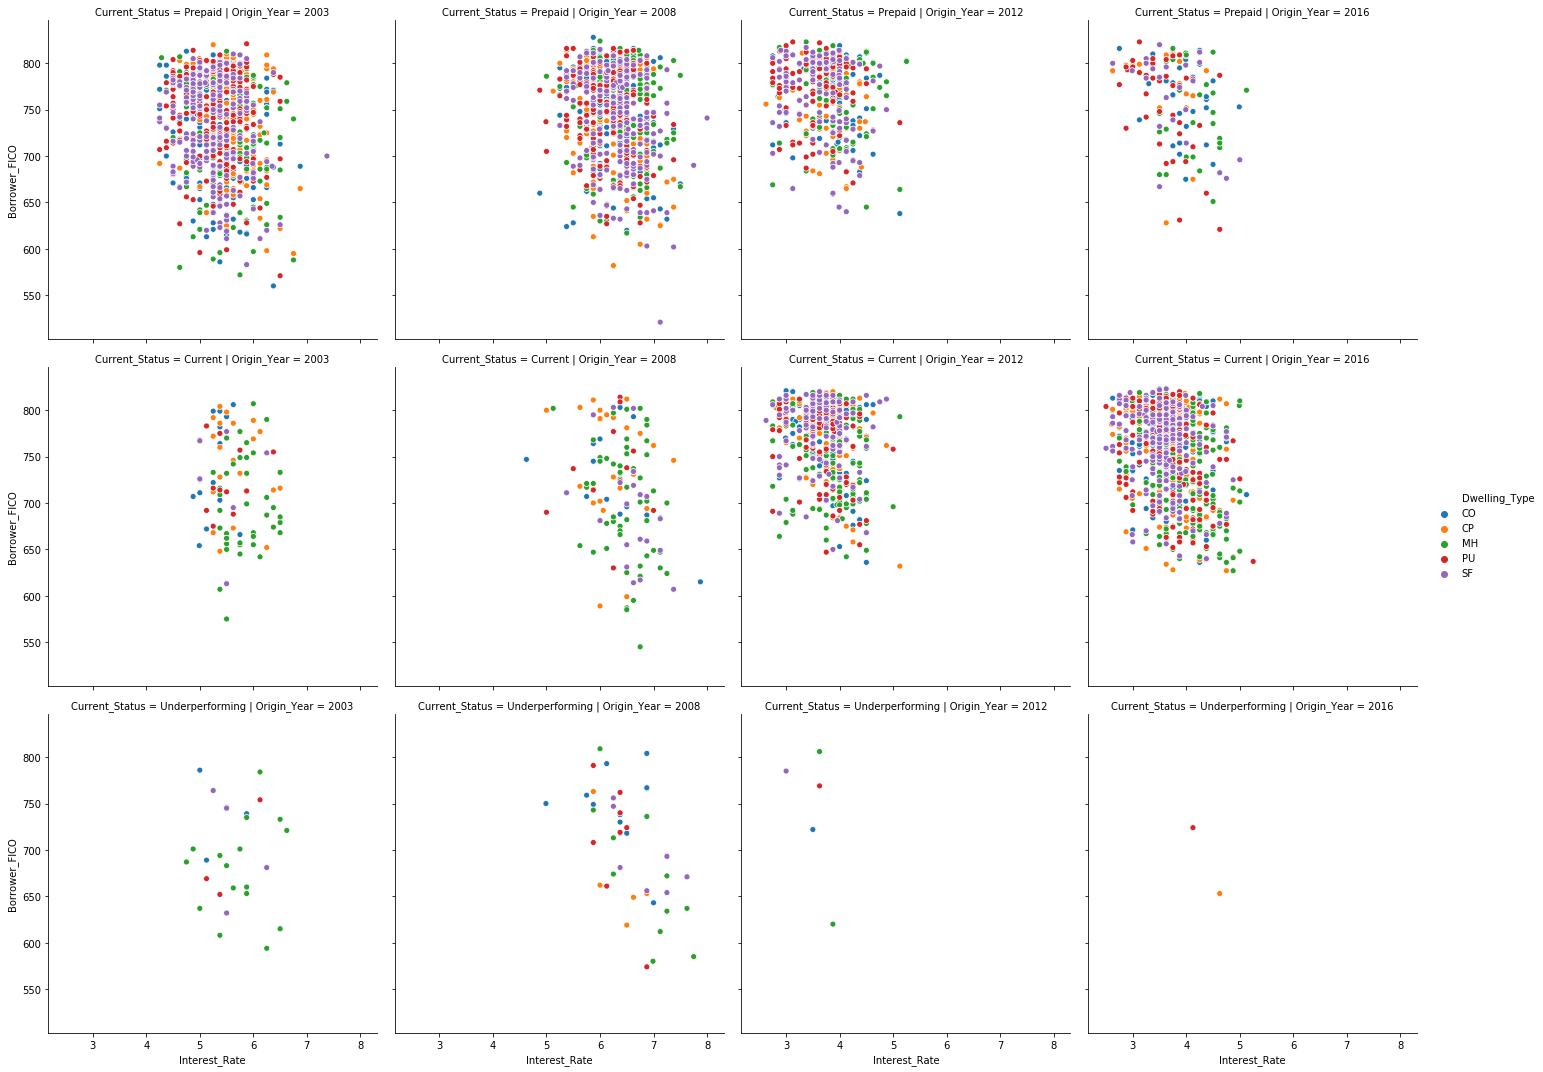

In [35]:
sns.relplot(y='Borrower_FICO', x='Interest_Rate', data=df3#.query('Current_Status != "Prepaid"'), #kind='line', 
            ,hue='Dwelling_Type',
            row='Current_Status', col='Origin_Year')
plt.show()